In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/covid-sentiment"

Mounted at /content/drive
/content/drive/MyDrive/covid-sentiment


In [2]:
! unzip folder_full.zip

Archive:  folder_full.zip
replace es/tok_mbert_256/dataset_dict.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: es/tok_mbert_256/dataset_dict.json  
  inflating: es/tok_mbert_256/train/data-00000-of-00001.arrow  
  inflating: es/tok_mbert_256/train/state.json  
  inflating: es/tok_mbert_256/train/dataset_info.json  
  inflating: es/tok_mbert_256/test/data-00000-of-00001.arrow  
  inflating: es/tok_mbert_256/test/state.json  
  inflating: es/tok_mbert_256/test/dataset_info.json  
  inflating: es/train_bal.parquet    
  inflating: es/test.parquet         
  inflating: es/label2id.json        
  inflating: es/id2label.json        
  inflating: es/meta.json            
 extracting: pt/tok_mbert_256/dataset_dict.json  
  inflating: pt/tok_mbert_256/train/data-00000-of-00001.arrow  
  inflating: pt/tok_mbert_256/train/state.json  
  inflating: pt/tok_mbert_256/train/dataset_info.json  
  inflating: pt/tok_mbert_256/test/data-00000-of-00001.arrow  
  inflating: pt/tok_mbert_256/tes

In [ ]:
%pip -q uninstall -y transformers tokenizers datasets accelerate huggingface_hub protobuf numpy pyarrow peft

%pip -q install \
  "protobuf<5.0.0" \
  "transformers==4.46.3" \
  "datasets==2.20.0" \
  "accelerate==0.34.2" \
  "tokenizers>=0.19.1" \
  "huggingface_hub>=0.24" \
  "safetensors>=0.4" \
  "sentencepiece>=0.1.99" \
  "numpy==1.26.4" \
  "pyarrow==15.0.2"

import os
os.kill(os.getpid(), 9)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 137.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 32.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behavi

In [1]:
import transformers, datasets, accelerate, google.protobuf as gp, numpy, pyarrow
import torch, sys, platform

print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("accelerate:", accelerate.__version__)
print("protobuf:", gp.__version__)
print("numpy:", numpy.__version__)
print("pyarrow:", pyarrow.__version__)
print("python:", sys.version.split()[0], "| torch:", torch.__version__, "| cuda:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("gpu:", torch.cuda.get_device_name(0))

transformers: 4.46.3
datasets: 2.20.0
accelerate: 0.34.2
protobuf: 4.25.8
numpy: 1.26.4
pyarrow: 15.0.2
python: 3.12.12 | torch: 2.9.0+cu126 | cuda: True
gpu: Tesla T4


In [2]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)


In [ ]:
import os, json, numpy as np, torch
from datasets import load_from_disk
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, EarlyStoppingCallback)

BASE_DIR = "/content/drive/MyDrive/covid-sentiment"
LANG_TAG = "pt"
SAVE_LANG_DIR = f"{BASE_DIR}/{LANG_TAG}"
TOK_DIR = f"{SAVE_LANG_DIR}/tok_mbert_256"

SEED = 42
torch.manual_seed(SEED);
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [ ]:
tok = load_from_disk(TOK_DIR)
with open(f"{SAVE_LANG_DIR}/label2id.json","r",encoding="utf-8") as f: label2id = json.load(f)
with open(f"{SAVE_LANG_DIR}/id2label.json","r",encoding="utf-8") as f: id2label = json.load(f)
num_labels = len(label2id)

MODEL_NAME = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels, id2label=id2label, label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_bal_counts = np.bincount(tok["train"]["labels"], minlength=num_labels)

def class_balanced_weights(counts, beta=0.99):
    counts = np.asarray(counts, dtype=float)
    eff_num = (1.0 - np.power(beta, counts)) / (1.0 - beta)
    w = 1.0 / np.maximum(eff_num, 1e-9)
    return (w / w.sum()) * len(w)

USE_LIGHT_WEIGHTS = False
if USE_LIGHT_WEIGHTS:
    w = class_balanced_weights(train_bal_counts, beta=0.99)
    class_weights = torch.tensor(w, dtype=torch.float)
    print("Light class weights:", w)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro", zero_division=0)
    return {"accuracy": acc, "precision_macro": prec, "recall_macro": rec, "f1_macro": f1}

from transformers import Trainer
import torch.nn as nn

class WeightedCELossTrainer(Trainer):
    def __init__(self, class_weights: torch.Tensor, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs["labels"]
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
USE_BF16 = torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 8
USE_FP16 = torch.cuda.is_available() and not USE_BF16

OUTPUT_DIR = f"{SAVE_LANG_DIR}/mbert_{LANG_TAG}_sentiment"

args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    weight_decay=0.01,
    seed=SEED,
    report_to="none",
    fp16=USE_FP16,
    bf16=USE_BF16,
)

if USE_LIGHT_WEIGHTS:
    trainer = WeightedCELossTrainer(
        class_weights=class_weights,
        model=model,
        args=args,
        train_dataset=tok["train"],
        eval_dataset=tok["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )
else:
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tok["train"],
        eval_dataset=tok["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

trainer.train()

BEST_DIR = f"{SAVE_LANG_DIR}/mbert_{LANG_TAG}_best"
model_to_save = trainer.model
model_to_save.save_pretrained(BEST_DIR)
tokenizer.save_pretrained(BEST_DIR)
with open(f"{BEST_DIR}/label2id.json","w",encoding="utf-8") as f: json.dump(label2id,f,ensure_ascii=False,indent=2)
with open(f"{BEST_DIR}/id2label.json","w",encoding="utf-8") as f: json.dump(id2label,f,ensure_ascii=False,indent=2)
print("Saved best model to:", BEST_DIR)

/usr/local/lib/python3.12/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipython-input-2083358069.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro
1,0.534300,0.584863,0.748289,0.555635,0.795900,0.604268
2,0.425000,0.797702,0.779214,0.603070,0.797667,0.643751
3,0.261600,0.815327,0.812928,0.617093,0.808879,0.670406


Saved best model to: /content/drive/MyDrive/covid-sentiment/pt/mbert_pt_best


In [8]:
import shutil, os
MODEL_DIR = BEST_DIR
ZIP_PATH  = f"{SAVE_LANG_DIR}/mbert_{LANG_TAG}_best.zip"

shutil.make_archive(ZIP_PATH.replace(".zip", ""), 'zip', MODEL_DIR)
print(f"Model zipped successfully:\n{ZIP_PATH}")

Model zipped successfully:
/content/drive/MyDrive/covid-sentiment/pt/mbert_pt_best.zip


In [ ]:
import numpy as np
import json
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

eval_res = trainer.evaluate(eval_dataset=tok["test"])
print("Raw eval from Trainer:")
print(json.dumps(eval_res, indent=2))

preds = trainer.predict(tok["test"])
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
metrics = {
    "accuracy": acc,
    "precision_macro": prec,
    "recall_macro": rec,
    "f1_macro": f1,
}
print("\nComputed metrics:")
print(json.dumps(metrics, indent=2))

Raw eval from Trainer:
{
  "eval_loss": 0.8153268098831177,
  "eval_accuracy": 0.8129277566539924,
  "eval_precision_macro": 0.617093212963728,
  "eval_recall_macro": 0.8088791775133645,
  "eval_f1_macro": 0.6704061682525578,
  "eval_runtime": 12.779,
  "eval_samples_per_second": 308.71,
  "eval_steps_per_second": 19.329,
  "epoch": 3.0
}

Computed metrics:
{
  "accuracy": 0.8129277566539924,
  "precision_macro": 0.617093212963728,
  "recall_macro": 0.8088791775133645,
  "f1_macro": 0.6704061682525578
}


In [ ]:
keys = list(id2label.keys())
first_key = keys[0]

if isinstance(first_key, str):
    target_names = [id2label[str(i)] for i in range(num_labels)]
else:
    target_names = [id2label[i] for i in range(num_labels)]

print("target_names:", target_names)

print("\nClassification report:")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=target_names,
    )
)

target_names: ['negative', 'neutral', 'positive']

Classification report:
              precision    recall  f1-score   support

    negative       0.35      0.82      0.49       315
     neutral       0.97      0.81      0.89      3373
    positive       0.53      0.79      0.63       257

    accuracy                           0.81      3945
   macro avg       0.62      0.81      0.67      3945
weighted avg       0.89      0.81      0.84      3945



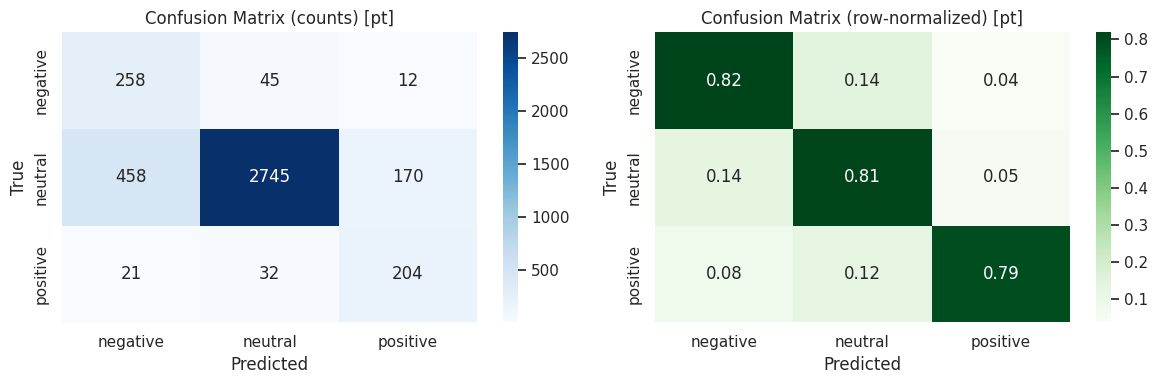

Saved figure to: /content/drive/MyDrive/covid-sentiment/pt/figs/cm_pt.png
Saved metrics to: /content/drive/MyDrive/covid-sentiment/pt/metrics_pt.csv


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set_theme()

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_labels)))
cm_norm = cm / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    ax=ax[0],
    xticklabels=target_names,
    yticklabels=target_names,
)
ax[0].set_title(f"Confusion Matrix (counts) [{LANG_TAG}]")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("True")

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Greens",
    ax=ax[1],
    xticklabels=target_names,
    yticklabels=target_names,
)
ax[1].set_title(f"Confusion Matrix (row-normalized) [{LANG_TAG}]")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("True")

plt.tight_layout()

figs_dir = os.path.join(SAVE_LANG_DIR, "figs")
os.makedirs(figs_dir, exist_ok=True)

fig_path = os.path.join(figs_dir, f"cm_{LANG_TAG}.png")
plt.savefig(fig_path, dpi=180)
plt.show()

metrics_df = pd.DataFrame([metrics])
metrics_path = os.path.join(SAVE_LANG_DIR, f"metrics_{LANG_TAG}.csv")
metrics_df.to_csv(metrics_path, index=False)

print("Saved figure to:", fig_path)
print("Saved metrics to:", metrics_path)